## Zhlukovanie - vyhodnotenie a interpretácia zhlukov - príklad 2

Rovnakýn postup ako v predošlom príklade si vieme demonštrovať aj na inom príklade. V tomto datasete budeme pracovať s dátami, ktoré charakterizujú zákazníkov. Každý z nich je popísaný:
* Gender - pohlavie
* Age - vek
* Annual Income - ročný príjem v dolároch
* Spending Score - index popisujúci tendenciu zákazníka nakupovať

In [1]:
# importujeme potrebné knižnice

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# načítame dáta do dátového rámca a vypíšeme prvých 5 riadkov

data = pd.read_csv('../data/customers.csv')
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


Najprv si dáta pripravíme jednoduchým predspracovaním:
* odstránime identifikátor zákazníka
* zakódujeme atribút pohlavie

In [3]:
data = data.drop(["CustomerID"], axis=1)
#data["Gender"] = data["Gender"].map({"Male":0, "Female":1})
data = pd.get_dummies(data,columns=["Gender"])
data.head()

,Age,Annual Income (k$),Spending Score (1-100),Gender_Female,Gender_Male
0,19,15,39,0,1
1,21,15,81,0,1
2,20,16,6,1,0
3,23,16,77,1,0
4,31,17,40,1,0


Rovnako ako v predošlom príklade identifikujeme vhodný počet zhlukov a natrénujeme model K-Means pre zvolený počet. Skúsime použiť obe kritériá  - aj `inertia` aj `silhouette` pre rozhodnutie. 

In [5]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

results_inertia = []
results_silhouette = []

K = range(2,10)

for k in K:
    model = KMeans(n_clusters=k)
    model.fit(data)
    predictions = model.predict(data)
    results_inertia.append(model.inertia_)
    results_silhouette.append(silhouette_score(data, predictions))
    
print("Skore Inertia:")
print(results_inertia)
print("Skore Silhouette:")
print(results_silhouette)

Skore Inertia:
[212938.7150895141, 143440.43314900761, 104463.19922884135, 75448.45165554191, 58396.839405039405, 51252.26183061117, 44402.753618722585, 40934.527039821776]
Skore Silhouette:
[0.29298136996751367, 0.38366377184202277, 0.4051292479311983, 0.443849645338732, 0.45176811980591935, 0.43766200713553516, 0.42722300208029473, 0.3965628912106168]


Aby sme mali lepší prehľad, môžeme si oba grafy vykresliť. Pomocou `subplot()` vieme vykresliť oba grafy súčasne vedľa seba.

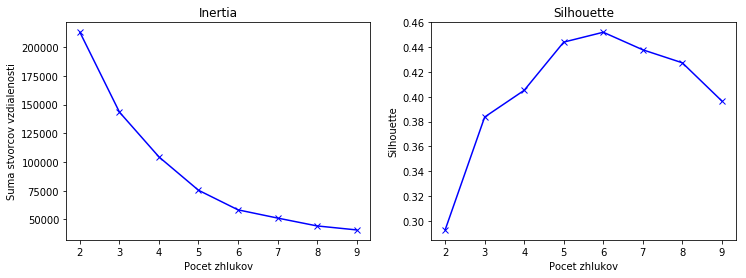

In [6]:
plt.figure(figsize=(12, 4)) # definujeme veľkosť obrázku (trocha natiahnuť do šírky, kvôli vykresleniu 2 vedľa seba)
plt.subplot(1, 2, 1) # 1-2-1 znamená, že vytvoríme 1 riadok, 2 stĺpce a kresliť budeme do 1.
plt.plot(K, results_inertia, 'bx-')
plt.xlabel('Pocet zhlukov')
plt.ylabel('Suma stvorcov vzdialenosti')
plt.title('Inertia')

plt.subplot(1, 2, 2) # 1-2-2 znamená, že vytvoríme 1 riadok, 2 stĺpce a kresliť budeme do 2.
plt.plot(K, results_silhouette, 'bx-')
plt.xlabel('Pocet zhlukov')
plt.ylabel('Silhouette')
plt.title('Silhouette')

plt.show() # show funkciu zavoláme až nakoniec, čím vykreslíme oba grafy naraz

Ideálny počet zhlukov sme odhalili a teraz natrénujeme K-Means model s daným počtom zhlukov. POužijeme natrénovaný model a príklady zatriedime do zhlukov. Vytvorenú premennú tak použijeme pre klasifikačný model pre popis zhlukov.

In [7]:
model = KMeans(n_clusters=6)
model.fit(data)
labels = model.predict(data)

In [8]:
# vypíšeme predikcie modelu

print(labels)

[4 5 4 5 4 5 4 5 4 5 4 5 4 5 4 5 4 5 4 5 4 5 4 5 4 5 4 5 4 5 4 5 4 5 4 5 4
 5 4 5 2 5 2 1 4 5 2 1 1 1 2 1 1 2 2 2 2 2 1 2 2 1 2 2 2 1 2 2 1 1 2 2 2 2
 2 1 2 1 1 2 2 1 2 2 1 2 2 1 1 2 2 1 2 1 1 1 2 1 2 1 1 2 2 1 2 1 2 2 2 2 2
 1 1 1 1 1 2 2 2 2 1 1 1 0 1 0 3 0 3 0 3 0 1 0 3 0 3 0 3 0 3 0 1 0 3 0 3 0
 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3
 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0]


Teraz natrénujeme klasifikátor, ktorým zhluky popíšeme.

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

dt = DecisionTreeClassifier(max_depth=4)   # Inicializácia stromového modelu   
dt.fit(data, labels)        # Trénovanie modelu na trénovacej množine 

y_dt = dt.predict(data)       # Otestovanie modelu na testovacej množine

from sklearn.metrics import accuracy_score,precision_score, recall_score # vypočítanie metrík kvality modelu

print(f"Presnosť (accuracy) modelu: {accuracy_score(labels, y_dt)}")

cm = confusion_matrix(labels, y_dt)  # vypísanie kontigenčnej tabuľky
print(cm)

Presnosť (accuracy) modelu: 0.99
[[39  0  0  0  0  0]
 [ 0 37  0  1  0  0]
 [ 0  0 45  0  0  0]
 [ 0  0  0 35  0  0]
 [ 0  0  0  0 21  0]
 [ 0  0  0  0  1 21]]


Stromový model vykreslíme pre odhadnutie pravidiel pre dané zhluky. Pokúsime sa odvodiť pravidlá pre popis jednotlivých zhlukov.

In [10]:
from sklearn import tree
from sklearn.tree import export_graphviz

with open("decision_tree.txt", "w") as f:
    f = tree.export_graphviz(dt, feature_names=data.columns.values, class_names=["0","1","2","3","4","5"], out_file=f)

### Úloha 13.6:

Pokúste sa pre identifikované zhluky vytvoriť aj vizualizácie priemerných hodnôt ich číselných atribútov. Porovnajte tieto s extrahovanými pravidlami, resp. so znalosťami viditeľnými zo stromovej štruktúry modelu. 

Index(['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Gender_Female',
       'Gender_Male'],
      dtype='object')


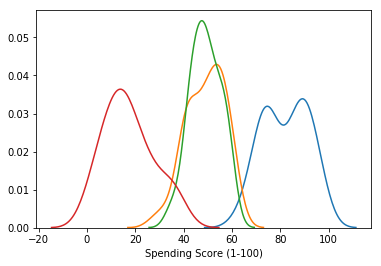

In [23]:
import seaborn as sns

cluster_0 = np.where(model.labels_==0)
cluster_1 = np.where(model.labels_==1)
cluster_2 = np.where(model.labels_==2)
cluster_3 = np.where(model.labels_==3)

data_cluster_0 = data.iloc[cluster_0] 
data_cluster_1 = data.iloc[cluster_1]
data_cluster_2 = data.iloc[cluster_2]
data_cluster_3 = data.iloc[cluster_3]

print(data.columns)

g = sns.distplot(data_cluster_0["Spending Score (1-100)"], hist= False)
g = sns.distplot(data_cluster_1["Spending Score (1-100)"], hist= False)
g = sns.distplot(data_cluster_2["Spending Score (1-100)"], hist= False)
g = sns.distplot(data_cluster_3["Spending Score (1-100)"], hist= False)